In [1]:
import sys
sys.path.remove('/home/ashesh.ashesh/code/Disentangle')

In [2]:
from IPython.display import display, HTML
import os
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import torch
import numpy as np
import seaborn as sns

from disentangle.data_loader.patch_index_manager import TilingMode
from disentangle.core.sampler_type import SamplerType
from disentangle.core.loss_type import LossType
from disentangle.data_loader.ht_iba1_ki67_rawdata_loader import SubDsetType
from disentangle.analysis.stitch_prediction import stitch_predictions
from disentangle.analysis.mmse_prediction import get_dset_predictions
from disentangle.analysis.forward_operator_parameters import get_forward_operator_parameters
from disentangle.core.psnr import PSNR
from finetunesplit.posterior_sampler import get_transform_obj, PosteriorSampler
from disentangle.core.psnr import RangeInvariantPsnr

from finetunesplit.asymmetric_transforms import TransformEnum
from finetunesplit.calibration.calibration_coverage import compute_for_one_batch
from finetunesplit.calibration.grid_search import grid_search
from finetunesplit.calibration.grid_search import plot_coverage_plot
from finetunesplit.calibration.grid_search import get_percentage_occurance



/localscratch/code/Disentangle/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%run ./nb_core/root_dirs.ipynb
setup_syspath_disentangle(False)
%run ./nb_core/disentangle_imports.ipynb

DATA_ROOT:	 /group/jug/ashesh/data/
CODE_ROOT:	 /localscratch/


In [5]:
def get_dtype(ckpt_fpath):
    if os.path.isdir(ckpt_fpath):
        ckpt_fpath = ckpt_fpath[:-1] if ckpt_fpath[-1] == '/' else ckpt_fpath
    elif os.path.isfile(ckpt_fpath):
        ckpt_fpath = os.path.dirname(ckpt_fpath)
    assert ckpt_fpath[-1] != '/'
    return int(ckpt_fpath.split('/')[-2].split('-')[0][1:])

In [6]:

# ckpt_dir = "/group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L0/14"
# ckpt_dir = "/group/jug/ashesh/training/disentangle/2504/D21-M3-S0-L0/12"
ckpt_dir = '/group/jug/ashesh/training/disentangle/2509/D25-M29-S0-L0/8'
assert os.path.exists(ckpt_dir)

image_size_for_grid_centers = None
custom_image_size = None
data_t_list = None #[0,1,2]
tiling_mode = TilingMode.ShiftBoundary

batch_size = 32
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Test 
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'



# coverage parameters.
# correlation preserving transform
corr_pres_trans=True
# enable circular padded tranlation transform
enable_translation_transform = False
# we oscillate around the best t with a small delta
delta_t = 0.1
# homography transforms.
aug_theta_max = 0.0
aug_theta_z_max = 0
aug_shift_max=0.0
enable_homography_transform = aug_theta_max > 0 or aug_theta_z_max > 0 or aug_shift_max > 0

# size of the block which is used to compute the correlation
elem_size = 10
mmse_count = 5
# error is computed from the first prediction
compute_error_from_first_prediction= True
k_forward_pass = 2

k_prediction_mode = 'entire'
# whether to enable the hflip, vflip and 90 degree rotation
with_transforms = True

In [7]:
dtype = get_dtype(ckpt_dir)
dtype

25

In [8]:
if with_transforms:
    ch1_transforms = [(TransformEnum.Rotate,{}),(TransformEnum.HFlip, {}),(TransformEnum.VFlip, {})]
    ch2_transforms = [(TransformEnum.Rotate,{}),(TransformEnum.HFlip, {}),(TransformEnum.VFlip, {})]
else:
    ch1_transforms = [(TransformEnum.Identity, {})]
    ch2_transforms = [(TransformEnum.Identity, {})]

if enable_translation_transform:
    ch1_transforms.append((TransformEnum.Translate, {}))
    ch2_transforms.append((TransformEnum.Translate, {}))

if enable_homography_transform:
    dct = {'theta_max':aug_theta_max, 'theta_z_max':aug_theta_z_max, 'shift_max':aug_shift_max, 'device': 'cuda'}
    print('Enabling homography transform', dct)
    ch1_transforms.append((TransformEnum.DeepInV, dct))
    ch2_transforms.append((TransformEnum.DeepInV, dct))

In [9]:
assert k_prediction_mode in ['entire', 'only_transformed', 'only_first']

In [10]:
%run ./nb_core/config_loader.ipynb

data:
  channel_idx_list:
  - 0
  - 1
  - 8
  channelwise_quantile: false
  clip_percentile: 1
  data_type: 25
  deterministic_grid: false
  dset_type: 5ms
  enable_gaussian_noise: false
  grid_size: 128
  image_size: 256
  input_has_dependant_noise: true
  input_idx: 2
  input_is_sum: false
  multiscale_lowres_count: null
  normalized_input: true
  num_channels: 3
  padding_mode: reflect
  padding_value: null
  poisson_noise_factor: -1
  randomized_channels: false
  sampler_type: 0
  synthetic_gaussian_scale: 100
  target_idx_list:
  - 0
  - 1
  target_separate_normalization: true
  threshold: 0.02
  train_aug_rotate: false
  use_one_mu_std: true
  val_grid_size: 128
datadir: /group/jug/ashesh/data/nikola_data/20240531/
exptname: 2509/D25-M29-S0-L0/8
git:
  branch: lyon_discriminator
  changedFiles:
  - disentangle/configs/nikola_with_transformer.py
  latest_commit: e248be3458cb944bb23f16a590ceecde6f4563ad
  untracked_files: []
hostname: gnode05
loss:
  denoisplit_w: 1.0
  free_bits: 

In [11]:
tokens = ckpt_dir.split('/')
idx = tokens.index('disentangle')
if config.model.model_type == 25 and tokens[idx+1] == '2312':
    config.model.model_type = ModelType.LadderVAERestrictedReconstruction

In [12]:

# from disentangle.core.lowres_merge_type import LowresMergeType


with config.unlocked():
    if 'depth3D' in config.data and config.data.depth3D > 1:
        config.data.mode_3D = True
        config.model.mode_3D = True

    if 'start_alpha' in config.data:
        print('Disabling the mixing augmentation, if any')
        config.data.start_alpha = None
        config.data.end_alpha = None
        config.data.alpha_weighted_target = False
            
    # config.model.skip_nboundary_pixels_from_loss = None
    # if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
    #     config.model.n_levels = 4
    # # if config.data.sampler_type == SamplerType.NeighborSampler:
    #     config.data.sampler_type = SamplerType.DefaultSampler
    #     config.loss.loss_type = LossType.Elbo
    #     config.data.grid_size = config.data.image_size
    # # if 'ch1_fpath_list' in config.data:
    #     config.data.ch1_fpath_list = config.data.ch1_fpath_list[:1]
    #     config.data.mix_fpath_list = config.data.mix_fpath_list[:1]
    # # if config.data.data_type == DataType.Pavia2VanillaSplitting:
    #     if 'channel_2_downscale_factor' not in config.data:
    #         config.data.channel_2_downscale_factor = 1
    # # if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
    #     config.model.init_channel_count = 64
    
    # if 'skip_receptive_field_loss_tokens' not in config.loss:
    #     config.loss.skip_receptive_field_loss_tokens = []
    
    # if dtype == DataType.HTIba1Ki67:
    #     config.data.subdset_type = SubDsetType.OnlyIba1P30
    #     config.data.empty_patch_replacement_enabled = False
    
    # if 'lowres_merge_type' not in config.model.encoder:
    #     config.model.encoder.lowres_merge_type = 0
    # if 'validtarget_random_fraction' in config.data:
    #     config.data.validtarget_random_fraction = None
    
    # if config.data.data_type == DataType.TwoDset:
    #     config.model.model_type = ModelType.LadderVae
    #     for key in config.data.dset1:
    #         config.data[key] = config.data.dset1[key]
    
    # if 'dump_kth_frame_prediction' in config.training:
    #     config.training.dump_kth_frame_prediction = None

    # # if 'input_is_sum' not in config.data:
    #     config.data.input_is_sum = False

In [13]:
dtype = config.data.data_type

if dtype in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
    data_dir = f'{DATA_ROOT}/sinosoid_without_test/sinosoid/'
elif dtype == DataType.OptiMEM100_014:
    data_dir = f'{DATA_ROOT}/microscopy/'
elif dtype == DataType.Prevedel_EMBL:
    data_dir = f'{DATA_ROOT}/Prevedel_EMBL/PKG_3P_dualcolor_stacks/NoAverage_NoRegistration/'
elif dtype == DataType.AllenCellMito:
    data_dir = f'{DATA_ROOT}/allencell/2017_03_08_Struct_First_Pass_Seg/AICS-11/'
elif dtype == DataType.SeparateTiffData:
    data_dir = f'{DATA_ROOT}/ventura_gigascience'
elif dtype == DataType.SemiSupBloodVesselsEMBL:
    data_dir = f'{DATA_ROOT}/EMBL_halfsupervised/Demixing_3P'
elif dtype == DataType.Pavia2VanillaSplitting:
    data_dir = f'{DATA_ROOT}/pavia2'
# elif dtype == DataType.ExpansionMicroscopyMitoTub:
    # data_dir = f'{DATA_ROOT}/expansion_microscopy_Nick/'
elif dtype == DataType.ShroffMitoEr:
    data_dir = f'{DATA_ROOT}/shrofflab/'
elif dtype == DataType.HTIba1Ki67:
    data_dir = f'{DATA_ROOT}/Stefania/20230327_Ki67_and_Iba1_trainingdata/'
elif dtype == DataType.BioSR_MRC:
    data_dir = f'{DATA_ROOT}/BioSR/'
elif dtype == DataType.ExpMicroscopyV2:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_v2/datafiles/'
elif dtype == DataType.TavernaSox2GolgiV2:
    data_dir = f'{DATA_ROOT}/TavernaSox2Golgi/acquisition2/'
elif dtype == DataType.Pavia3SeqData:
    data_dir = f'{DATA_ROOT}/pavia3_sequential_cropped/'
elif dtype == DataType.NicolaData:
    data_dir = f'{DATA_ROOT}/nikola_data/20240531/'
elif dtype == DataType.Dao3ChannelWithInput:
    data_dir = f'{DATA_ROOT}/Dao4Channel/'
elif dtype == DataType.Dao3Channel:
    data_dir = f'{DATA_ROOT}/Dao3Channel/'
elif dtype == DataType.SilvioLabCSHLData:
    data_dir = f'{DATA_ROOT}/svilen_cshl2024/'
elif dtype == DataType.ExpMicroscopyV3:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_v4/405_NHS_488BODIPY/'
elif dtype == DataType.Elisa3DData:
    data_dir = f'{DATA_ROOT}/Elisa3D/'

In [14]:
# config.model.noise_model_ch1_fpath = config.model.noise_model_ch1_fpath.replace('/home/ashesh.ashesh/training/', '/group/jug/ashesh/training_pre_eccv/')
# config.model.noise_model_ch2_fpath = config.model.noise_model_ch2_fpath.replace('/home/ashesh.ashesh/training/', '/group/jug/ashesh/training_pre_eccv/')

In [15]:
%run ./nb_core/disentangle_setup.ipynb


Loading from /group/jug/ashesh/data//nikola_data/20240531/Set1/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/20240531/Set2/uSplit_5ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/20240531/Set3/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/20240531/Set4/uSplit_5ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/20240531/Set5/uSplit_5ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/20240531/Set6/uSplit_5ms.nd2
ND2 dimensions: {'P':

/localscratch/code/Disentangle/.venv/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading from epoch 271
Model has 20.249M parameters


In [16]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

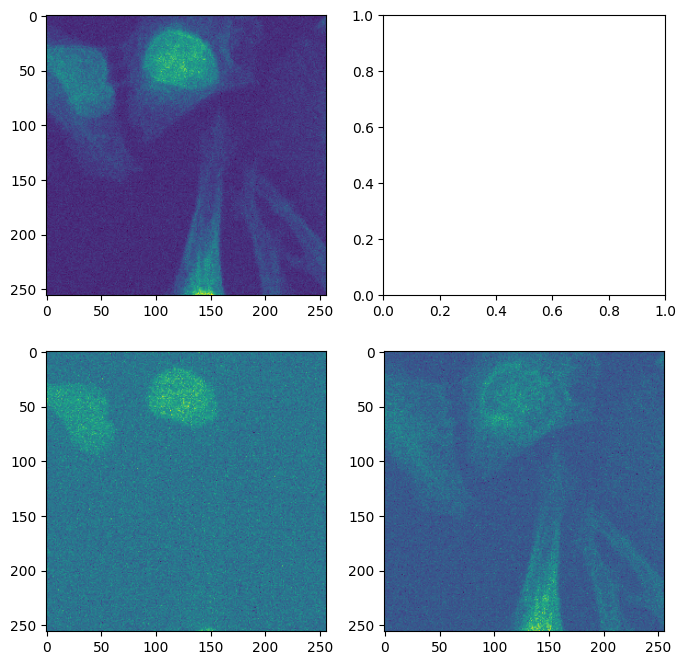

In [17]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
ncols = len(tar_tmp)
nrows = 2
_,ax = plt.subplots(figsize=(4*ncols,4*nrows),ncols=ncols,nrows=nrows)
for i in range(min(ncols,len(inp_tmp))):
    ax[0,i].imshow(inp_tmp[i])

for channel_id in range(ncols):
    ax[1,channel_id].imshow(tar_tmp[channel_id])

In [18]:
if data_t_list is not None:
    val_dset.reduce_data(t_list=data_t_list)

### Finding the optimal mixing ratio.

In [19]:


pred_tiled, rec_loss, logvar_tiled, patch_psnr_tuple, pred_std_tiled, _ = get_dset_predictions(model, val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=2,
                                                model_type = config.model.model_type,
                                              )
tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp))
pred = stitch_predictions(pred_tiled,val_dset )
if 'target_idx_list' in config.data and config.data.target_idx_list is not None and len(config.data.target_idx_list) > pred[0].shape[-1]:
    # it makes it a list. donot make it unless necessary.
    pred = [pred[i][...,:len(config.data.target_idx_list)] for i in range(len(pred))]


Getting predictions: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]


Patch wise PSNR, as computed during training [28.55 37.34] 32.945


In [20]:
mean_tar = model.data_mean['target'].cpu().numpy()
std_tar = model.data_std['target'].cpu().numpy()
assert mean_tar.shape == (1,2,1,1)
assert mean_tar.shape == std_tar.shape

inp_arr = []
tar_arr = []
for i in tqdm(range(len(val_dset))):
    inp, tar = val_dset[i]
    inp_arr.append(inp[None,:1])
    tar_arr.append((tar - mean_tar)/std_tar)
normalized_inp_patches = np.concatenate(inp_arr,axis=0)
normalized_tar_patches = np.concatenate(tar_arr,axis=0)
del inp_arr, tar_arr
# inp_stitched = stitch_predictions(inp_arr, val_dset)
# inp_stitched = [x[...,0] for x in inp_stitched]
# tar_stitched = stitch_predictions(tar_arr, val_dset)

100%|██████████| 1440/1440 [00:00<00:00, 2658.24it/s]


100%|██████████| 50/50 [00:08<00:00,  5.59it/s]


Best t value: 0.3


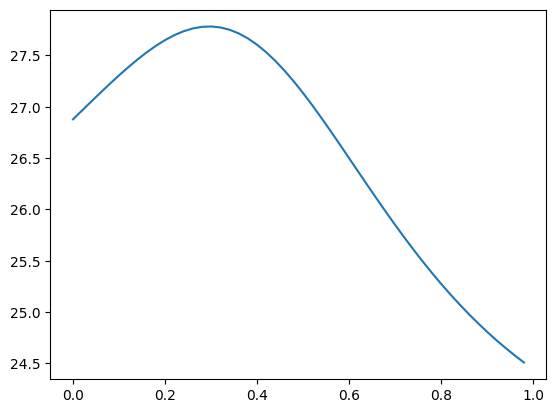

In [21]:

mixing_t, mu, sigma = get_forward_operator_parameters(val_dset, normalized_tar_patches, normalized_inp_patches, plot=True)
forward_operator_params = {
    'mixing_t_min': max(0.1,mixing_t - delta_t),
    'mixing_t_max': min(0.9,mixing_t + delta_t),
    'mu': mu,
    'sigma': sigma,
}


In [22]:

tar_st = stitch_predictions(normalized_tar_patches, val_dset)
inp_st = stitch_predictions(normalized_inp_patches, val_dset)
inp_est = [x[...,0]*mixing_t + x[...,1]*(1-mixing_t) for x in tar_st] if isinstance(tar_st, list) else tar_st[...,0]*mixing_t + tar_st[...,1]*(1-mixing_t)
inp_est = [x*sigma + mu for x in inp_est] if isinstance(inp_est, list) else inp_est*sigma + mu
# PSNR(inp_st[0][...,0], inp_est[0])

In [23]:
nTar = pred[0].shape[-1]
is_list_prediction = isinstance(pred, list)
tar_unnorm = (val_dset._data if not is_list_prediction else [val_dset.dsets[i]._data for i in range(len(val_dset.dsets))])

if "target_idx_list" in config.data and config.data.target_idx_list is not None:
    nTar =len(config.data.target_idx_list)

if 'input_idx' in config.data and config.data.input_idx is not None:
    inp_unnorm = [x[...,config.data.input_idx] for x in tar_unnorm] if is_list_prediction else tar_unnorm[...,config.data.input_idx]
    tar_unnorm = [x[...,:nTar] for x in tar_unnorm] if is_list_prediction else tar_unnorm[...,:nTar]
else:
    inp_unnorm = [x.mean(axis=-1) for x in tar_unnorm]



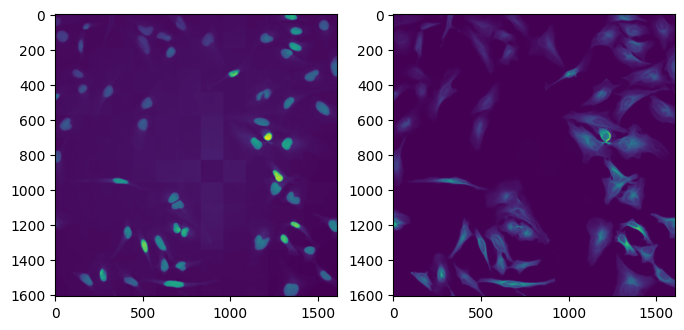

In [24]:
_,ax = plt.subplots(figsize=(8,4),ncols=2)
if is_list_prediction:
    ax[0].imshow(pred[0][0,...,0])
    ax[1].imshow(pred[0][0,...,1])
else:
    ax[0].imshow(pred[0,...,0])
    ax[1].imshow(pred[0,...,1])

### A model to yield augmented predictions.

In [25]:
import torch.nn as nn 
class NnModel(nn.Module):
    def __init__(self, model):
        super(NnModel, self).__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)[0]

singleoutput_model = NnModel(model).cuda()

In [26]:

transform_all = get_transform_obj(ch1_transforms, ch2_transforms, correlation_preserving_transforms=corr_pres_trans)
aug_model = PosteriorSampler(singleoutput_model, transform_all, forward_operator_params=forward_operator_params, k_predictions=mmse_count,
                                       k_prediction_mode=k_prediction_mode, k_forward_pass=k_forward_pass,)

Transforms for Ch1: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Transforms for Ch2: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Using correlation preserving transforms
Using transform types: {0: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')], 1: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')]}
[PosteriorSampler] k_prediction_mode: entire k_forward_pass: 2
[PosteriorSampler] mixing_t range: [0.19999999999999998, 0.4], mu: 0.0739951781134768, sigma: 1.3139886388854503, gaussian_noise_std: None


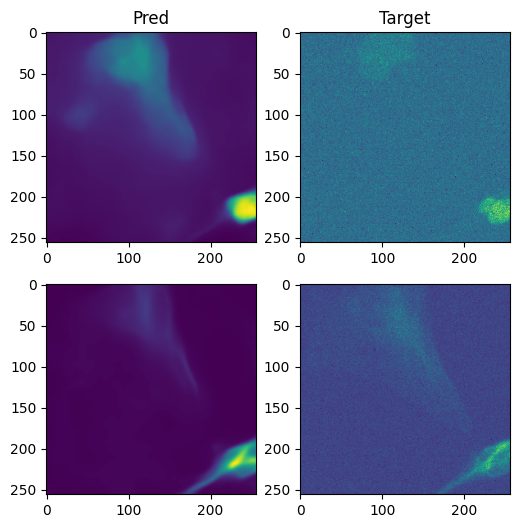

In [27]:
dloader = DataLoader(val_dset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
for batch in dloader:
    inp_b, tar_b = batch
    break

with torch.no_grad():
    output, pred1_mmse = aug_model(inp_b.cuda())
    output = [x.cpu().numpy() for x in output]
    pred1_mmse = pred1_mmse.cpu().numpy()

_,ax = plt.subplots(figsize=(6,6),ncols=2,nrows=2)
img_idx = np.random.randint(low=0, high=len(tar_b))
ax[0,0].set_title('Pred')
ax[0,1].set_title('Target')
ax[0,0].imshow(output[0][img_idx,0])
ax[0,1].imshow(tar_b[img_idx,0])
ax[1,0].imshow(output[0][img_idx,1])
ax[1,1].imshow(tar_b[img_idx,1])

In [28]:
if custom_image_size is None:
    skip_pixels = config.data.image_size - image_size_for_grid_centers
else:
    skip_pixels = custom_image_size - image_size_for_grid_centers

In [29]:
# # Looking at the sanity of LC setup.


# _,ax = plt.subplots(figsize=(15,3),ncols=5)
# idx = np.random.randint(len(val_dset    ))
# print(idx)
# inp, tar = val_dset[idx]
# ax[0].imshow(inp[0])
# ax[1].imshow(inp[1])
# ax[2].imshow(inp[2])
# ax[3].imshow(tar[0])
# ax[4].imshow(tar[1])

# with torch.no_grad():
#     inp_c = torch.Tensor(inp[None]).cuda()
#     pred, _  = model(inp_c)

# with torch.no_grad():
#     pred2, inp_c2 = aug_model.one_forward_pass(pred, inp_c[:,1:])

# _,ax = plt.subplots(figsize=(15,3),ncols=5)
# # idx = np.random.randint(len(val_dset    ))
# ax[0].imshow(inp_c2[0,0].cpu().numpy())
# ax[1].imshow(inp_c2[0,1].cpu().numpy())
# ax[2].imshow(inp_c2[0,2].cpu().numpy())
# ax[3].imshow(pred2[0,0].cpu().numpy())
# ax[4].imshow(pred2[0,1].cpu().numpy())

# with torch.no_grad():
#     pred3, inp_c3 = aug_model.one_forward_pass(pred2, inp_c[:,1:])

# _,ax = plt.subplots(figsize=(15,3),ncols=5)
# # idx = np.random.randint(len(val_dset    ))
# ax[0].imshow(inp_c3[0,0].cpu().numpy())
# ax[1].imshow(inp_c3[0,1].cpu().numpy())
# ax[2].imshow(inp_c3[0,2].cpu().numpy())
# ax[3].imshow(pred3[0,0].cpu().numpy())
# ax[4].imshow(pred3[0,1].cpu().numpy())

In [30]:
# mmse_count = 5

In [31]:

pred_b_list = []
var_list = []
err_list  = []
one_step_pred_mmse_list = []
dloader = DataLoader(val_dset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
for batch in tqdm(dloader):
    with torch.no_grad():
        inp_b, tar_b = batch
        tar_b_normalized = model.normalize_target(tar_b.cuda()).cpu().numpy()
        pred_b, one_step_pred_mmse = aug_model(inp_b.cuda())
        
        pred_b = [x.cpu().numpy()[:,None] for x in pred_b]
        pred_b = np.concatenate(pred_b, axis=1)
        one_step_pred_mmse = one_step_pred_mmse.cpu().numpy()
        
        
        ec_pred_b = pred_b
        ec_tar_b_normalized = tar_b_normalized
        ec_one_step_pred_mmse = one_step_pred_mmse
        if skip_pixels > 1:
            ec_pred_b = pred_b[...,skip_pixels//2:-skip_pixels//2,skip_pixels//2:-skip_pixels//2]
            ec_tar_b_normalized = tar_b_normalized[...,skip_pixels//2:-skip_pixels//2,skip_pixels//2:-skip_pixels//2]
            ec_one_step_pred_mmse = one_step_pred_mmse[...,skip_pixels//2:-skip_pixels//2,skip_pixels//2:-skip_pixels//2]
        
        var_b, err_b = compute_for_one_batch(ec_pred_b, ec_tar_b_normalized, elem_size=elem_size,mmse_sample_for_error=ec_one_step_pred_mmse if compute_error_from_first_prediction else None,)
        one_step_pred_mmse_list.append(one_step_pred_mmse)
        # compute for one batch, both calibration and coverage. 
        pred_b_list.append(pred_b[:,0])
        var_list.append(var_b)
        err_list.append(err_b)

pred_b = np.concatenate(pred_b_list, axis=0)
var = np.concatenate(var_list, axis=0)
err = np.concatenate(err_list, axis=0)
one_step_pred_mmse = np.concatenate(one_step_pred_mmse_list, axis=0)

100%|██████████| 45/45 [02:19<00:00,  3.11s/it]


In [32]:
pred_stitched  = stitch_predictions(pred_b, val_dset)
pred_one_step_stitched = stitch_predictions(one_step_pred_mmse, val_dset)

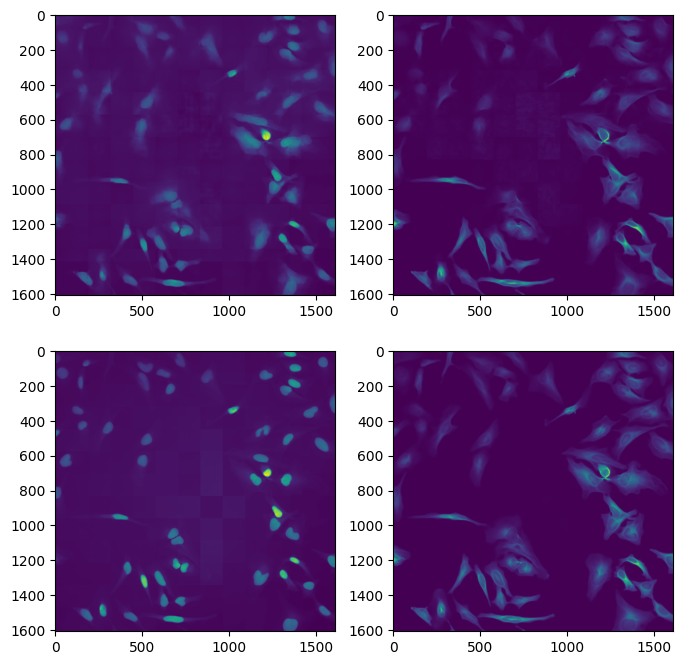

In [33]:
_,ax = plt.subplots(figsize=(8,8),ncols=2,nrows=2)
if is_list_prediction:
    ax[0,0].imshow(pred_stitched[0][0,...,0])
    ax[0,1].imshow(pred_stitched[0][0,...,1])
    ax[1,0].imshow(pred_one_step_stitched[0][0,...,0])
    ax[1,1].imshow(pred_one_step_stitched[0][0,...,1])
else:
    ax[0,0].imshow(pred_stitched[0,...,0])
    ax[0,1].imshow(pred_stitched[0,...,1])
    ax[1,0].imshow(pred_one_step_stitched[0,...,0])
    ax[1,1].imshow(pred_one_step_stitched[0,...,1])

In [34]:
tar_unnorm[0].shape

(1608, 1608, 2)

In [35]:
is_list_prediction

False

In [36]:
if is_list_prediction:
    print(RangeInvariantPsnr(tar_unnorm[0][0,...,0]*1.0, pred_stitched[0][0,...,0]).item())
else:
    print(RangeInvariantPsnr(tar_unnorm[0,...,0]*1.0, pred_stitched[0,...,0]).item())

26.41805648803711


In [37]:
factors = []
offsets = []
achieved_percentiles = []
for ch_idx in range(var.shape[1]):
    print('Starting the grid search')
    factor_ch, offset_ch, achieved_percentile_ch = grid_search(err[:,ch_idx], var[:,ch_idx], init_delta=10, init_factor=10,around_center=False)
    factors.append(factor_ch)
    offsets.append(offset_ch)
    achieved_percentiles.append(achieved_percentile_ch)
    
    print('')


Starting the grid search
0.73 10 D0
2.58 20 D0
4.59 30 D0
6.44 40 D0
Upscaling 10 -> 20
8.27 50 D0
11.88 70 D0
15.30 90 D0
18.76 110 D0
Upscaling 20 -> 40
22.17 130 D0
28.81 170 D0
34.82 210 D0
40.11 250 D0
Upscaling 40 -> 80
44.67 290 D0
52.25 370 D1
44.67 290 D2
48.68 330.0 D2
50.46 350.0 D3
48.68 330.0 D4
49.59 340.0 D4
50.03 345.0 D5
49.59 340.0 D6
49.82 342.5 D6
49.92 343.75 D6
50.03 345.0 D7

Starting the grid search
3.39 10 D0
9.91 20 D0
15.52 30 D0
20.08 40 D0
Upscaling 10 -> 20
23.69 50 D0
29.22 70 D0
33.02 90 D0
35.96 110 D0
Upscaling 20 -> 40
38.29 130 D0
41.76 170 D0
44.35 210 D0
46.32 250 D0
Upscaling 40 -> 80
47.93 290 D0
50.45 370 D1
47.93 290 D2
49.29 330.0 D2
49.89 350.0 D2
50.45 370.0 D3
49.89 350.0 D4
50.17 360.0 D5
50.03 355.0 D5
49.96 352.5 D6
50.03 355.0 D7



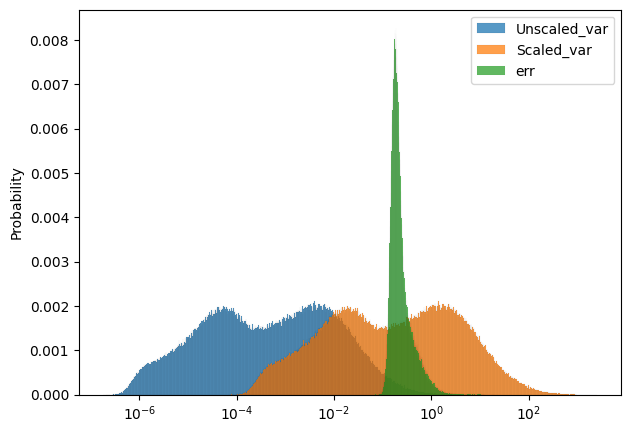

In [38]:

_,ax = plt.subplots(figsize=(7,5))
log_scale = True
ch_idx = 1
sns.histplot(var[:,ch_idx,:4].reshape(-1,), bins=1000,log_scale=log_scale, ax=ax, label='Unscaled_var', stat='probability')
sns.histplot(factors[ch_idx]*var[:,ch_idx,:4].reshape(-1,) + offsets[ch_idx], bins=1000,log_scale=log_scale, ax=ax, label='Scaled_var', stat='probability')
sns.histplot(err[:,ch_idx], bins=1000,log_scale=log_scale, ax=ax, label='err', stat='probability')
plt.legend()

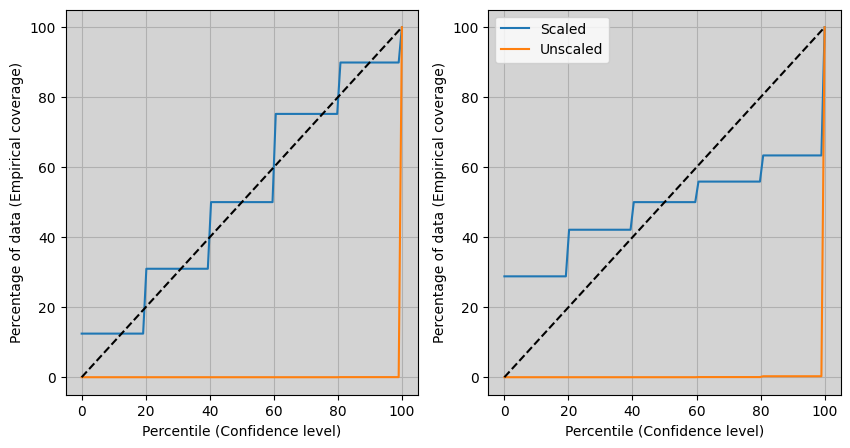

In [39]:
data_left_oriented = plot_coverage_plot(var, err, factors, offsets, around_center=False)

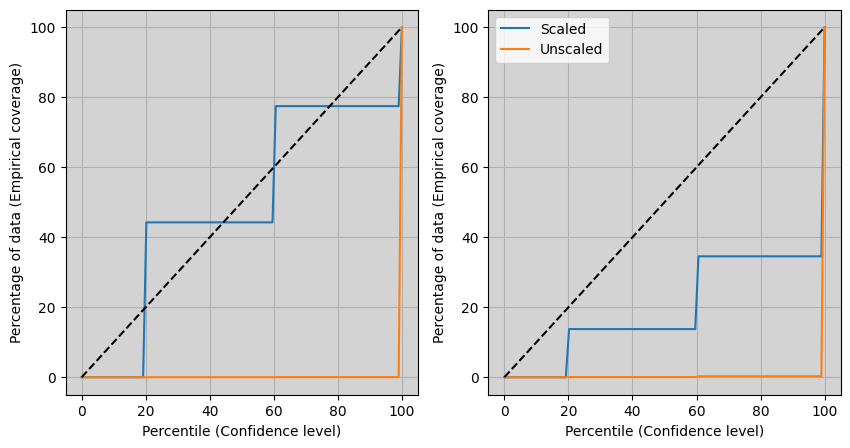

In [40]:
data_centered = plot_coverage_plot(var, err, factors, offsets, around_center=True)

In [41]:
perfect = np.linspace(0,100,100)
for col_idx in range(var.shape[1]):
    act = data_centered[col_idx]['scaled'][1]
    mean_err = np.abs(perfect - act).mean() 
    max_err = np.abs(perfect - act).max()
    print(f'Centered: Channel {col_idx} MAE {mean_err:.2f}, MAX Err {max_err:.2f}')

Centered: Channel 0 MAE 10.04, MAX Err 24.04
Centered: Channel 1 MAE 30.02, MAX Err 64.44


In [42]:
perfect = np.linspace(0,100,100)
for col_idx in range(var.shape[1]):
    act = data_left_oriented[col_idx]['scaled'][1]
    mean_err = np.abs(perfect - act).mean() 
    max_err = np.abs(perfect - act).max()
    print(f'LeftOriented: Channel {col_idx} MAE {mean_err:.2f}, MAX Err {max_err:.2f}')

LeftOriented: Channel 0 MAE 5.29, MAX Err 14.63
LeftOriented: Channel 1 MAE 15.23, MAX Err 35.62


In [43]:
# LeftOriented: Channel 0 MAE 5.19, MAX Err 12.85
# LeftOriented: Channel 1 MAE 6.48, MAX Err 13.62
# Centered: Channel 0 MAE 9.86, MAX Err 19.88
# Centered: Channel 1 MAE 12.47, MAX Err 24.28


In [44]:
outs = []
inp, _ = val_dset[0]
inp = torch.Tensor(inp[None]).cuda()
for _ in range(5):
    out,_ = model(inp)
    outs.append(out.detach().cpu().numpy())

In [45]:
np.abs(outs[0] - outs[1]).max()

np.float32(0.44326222)